In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from causallearn.search.ConstraintBased.PC import pc
from causallearn.search.FCMBased.ANM.ANM import ANM
from causallearn.utils.cit import kci
from causallearn.utils.KCI.PolynomialKernel import PolynomialKernel


from dataset import EarthSystemsDataset


In [2]:
data_var_names = ['global_temp', 'electricity', 'co2', 'ch4']
y_vals = ['temp_change']
lags = 15

earth_data = EarthSystemsDataset(data_var_names, y_vals=y_vals, val_frac=0.1, lags=lags, mode='ann')
earth_data.full_mode()
earth_data.data

temp_change  elec_generation  co2_average  ch4_average
year month                                                        
1983 Jul           0.18          220.447       342.14      1625.94
     Aug           0.35          230.193       340.62      1628.06
     Sep           0.37          195.817       340.53      1638.44
     Oct           0.17          183.137       341.75      1644.79
     Nov           0.30          183.171       342.83      1642.60
...                 ...              ...          ...          ...
2023 May           0.94          327.533       420.56      1920.00
     Jun           1.08          356.672       419.57      1915.94
     Jul           1.19          425.611       417.85      1914.56
     Aug           1.19          423.934       416.59      1919.15
     Sep           1.48          358.136       416.99      1927.35

[483 rows x 4 columns]

In [3]:
d = earth_data.data.to_numpy()
# kci = CIT(d, 'kci', kernelZ='Gaussian')
cg = pc(d, verbose=True)

  0%|          | 0/4 [00:00<?, ?it/s]

0 dep 1 | () with p-value 0.000000

0 dep 2 | () with p-value 0.000000

0 dep 3 | () with p-value 0.000000

1 dep 0 | () with p-value 0.000000

1 dep 2 | () with p-value 0.000000

1 dep 3 | () with p-value 0.000000

2 dep 0 | () with p-value 0.000000

2 dep 1 | () with p-value 0.000000

2 dep 3 | () with p-value 0.000000

3 dep 0 | () with p-value 0.000000

3 dep 1 | () with p-value 0.000000

3 dep 2 | () with p-value 0.000000

0 ind 1 | (2,) with p-value 0.581004

0 ind 1 | (3,) with p-value 0.671743

0 dep 2 | (1,) with p-value 0.000000

0 dep 2 | (3,) with p-value 0.000000

0 dep 3 | (1,) with p-value 0.000000

0 ind 3 | (2,) with p-value 0.416158

1 ind 0 | (2,) with p-value 0.581004

1 ind 0 | (3,) with p-value 0.671743

1 dep 2 | (0,) with p-value 0.000000

1 dep 2 | (3,) with p-value 0.005128

1 dep 3 | (0,) with p-value 0.000000

1 dep 3 | (2,) with p-value 0.001082

2 dep 0 | (1,) with p-value 0.000000

2 dep 0 | (3,) with p-value 0.000000

2 dep 1 | (0,) with p-value 0.000000

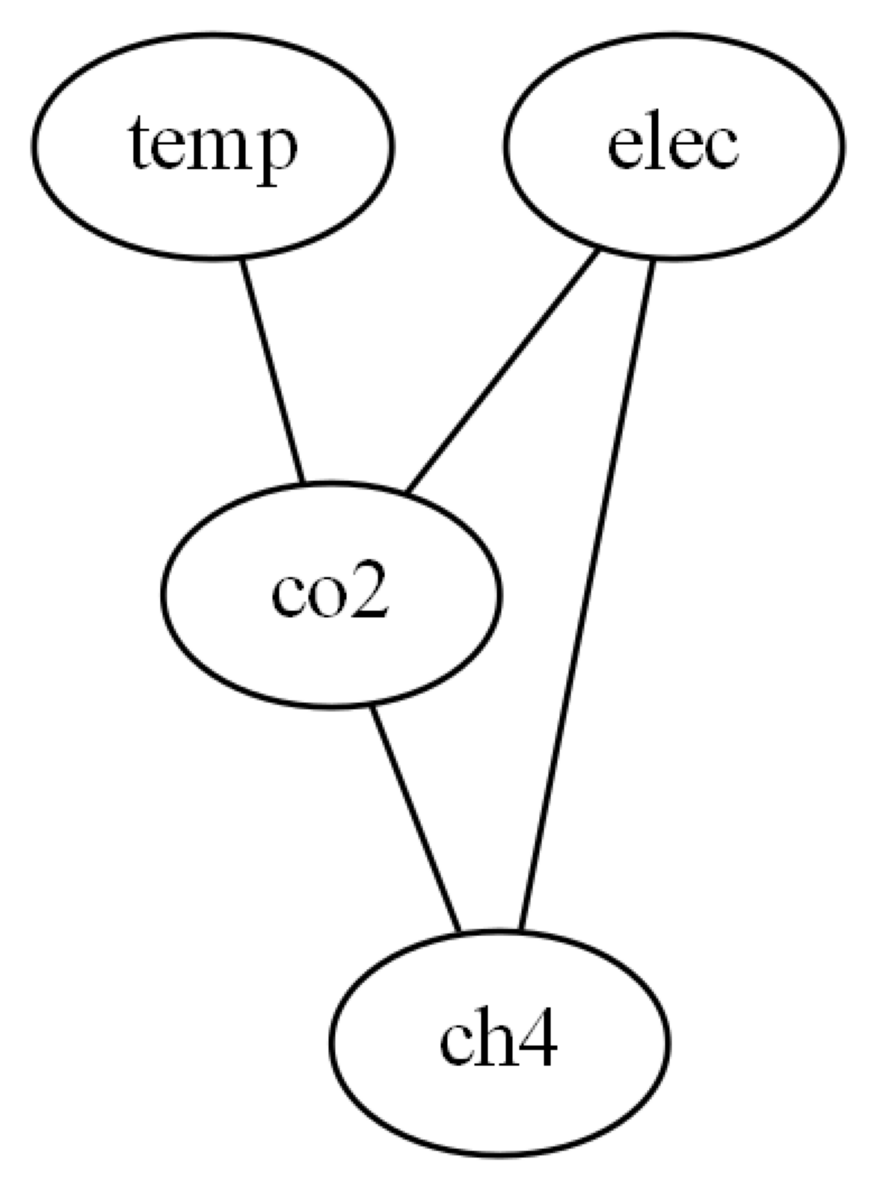

In [4]:
cg.draw_pydot_graph(labels=['temp', 'elec', 'co2', 'ch4'])

In [5]:
cg.G.graph

array([[ 0,  0, -1,  0],
       [ 0,  0, -1, -1],
       [-1, -1,  0, -1],
       [ 0, -1, -1,  0]])

In [6]:
for i in range(earth_data.data.shape[1]):
    for j in range(i):
        x, y = earth_data.data.iloc[:, i], earth_data.data.iloc[:, j]
        anm = ANM(kernelX='Linear', kernelY='Gaussian')
        p_xy, p_yx = anm.cause_or_effect(x.to_numpy().reshape(-1,1), y.to_numpy().reshape(-1,1))

        print(f'{earth_data.data.columns[i]} --- {earth_data.data.columns[j]}: {p_xy:.5f}, {p_yx:.5f}')

elec_generation --- temp_change: 0.03512, 0.42396
co2_average --- temp_change: 0.02658, 0.11270
co2_average --- elec_generation: 0.00001, 0.00000
ch4_average --- temp_change: 0.01970, 0.33895
ch4_average --- elec_generation: 0.11450, 0.00000
ch4_average --- co2_average: 0.30755, 0.12275


In [7]:
from scipy.stats import linregress

x, y = earth_data.data['ch4_average'], earth_data.data['temp_change']
anm = ANM()
p_xy, p_yx = anm.cause_or_effect(x.to_numpy().reshape(-1,1), y.to_numpy().reshape(-1,1))

In [8]:
p_xy, p_yx

(0.003360045682308077, 0.0)

### Manual verification that CO2 affects global_temp

Text(0.5, 1.0, 'Residuals of y --> x')

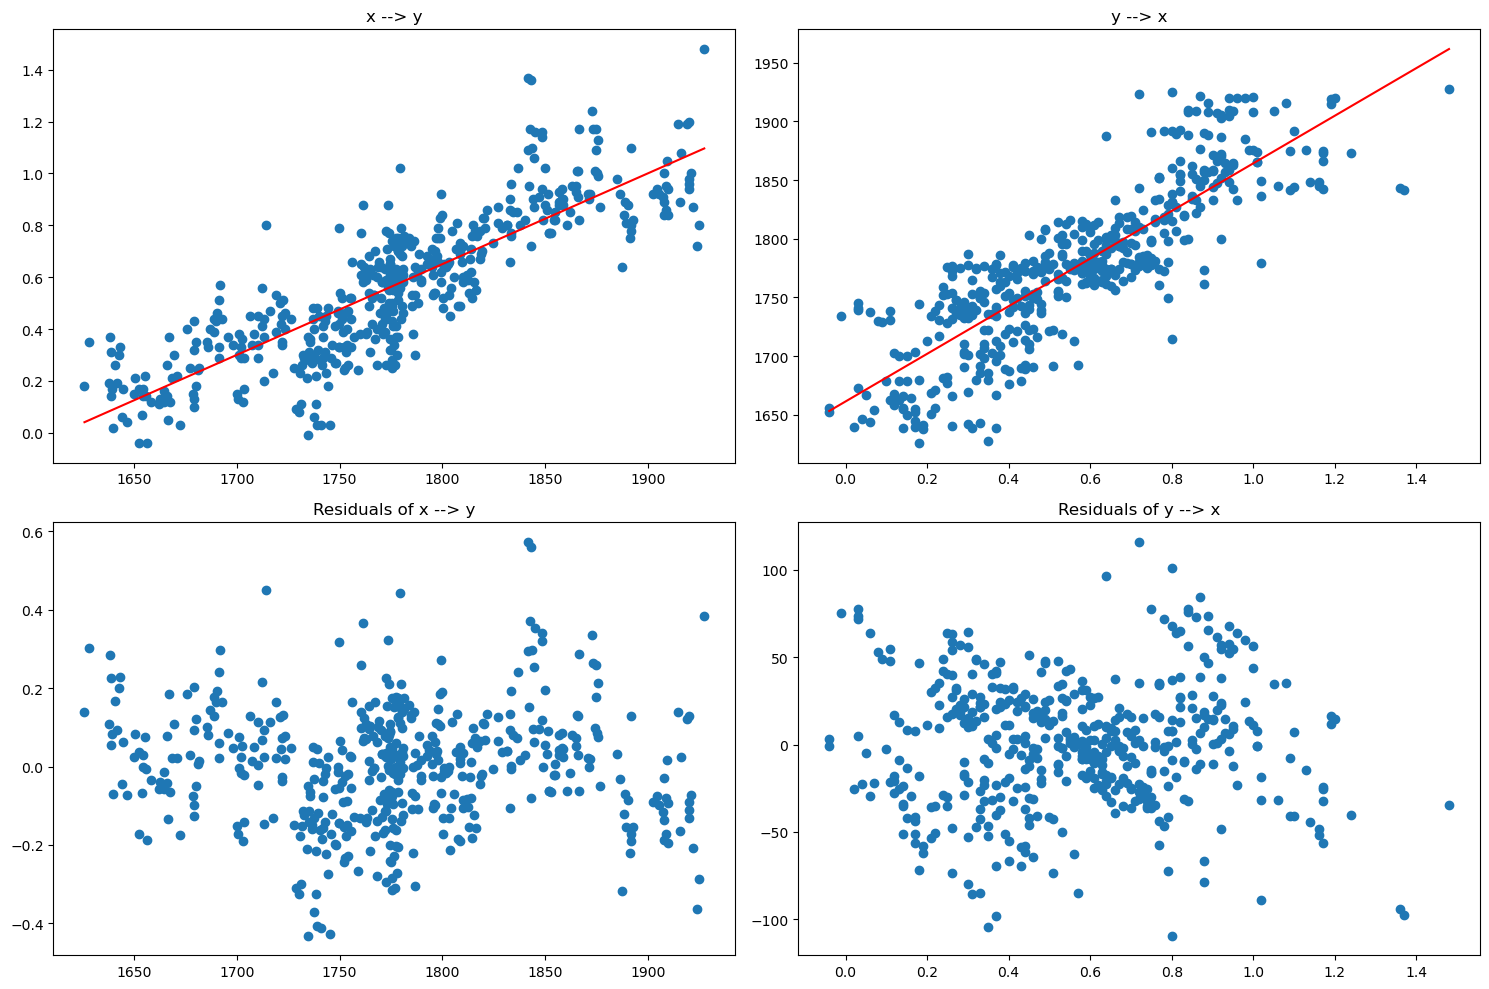

In [9]:
# testing causal relationship in x --> y
reg_xy = linregress(x,y)
m_xy, b_xy = reg_xy.slope, reg_xy.intercept

# testing causal relationship in y --> x
reg_yx = linregress(y,x)
m_yx, b_yx = reg_yx.slope, reg_yx.intercept


t_xy = np.linspace(x.min(), x.max(), 2500)
t_yx = np.linspace(y.min(), y.max(), 2500)

# Plot lines of best fit and residuals
fig, axes = plt.subplots(2, 2, figsize=(15,10))

# Plot points and regression line for x --> y
axes[0,0].scatter(x,y)
axes[0,0].plot(t_xy, m_xy*t_xy + b_xy, color='red')
axes[0,0].set_title('x --> y')

# Plot points and regression line for y --> x
axes[0,1].scatter(y,x)
axes[0,1].plot(t_yx, m_yx*t_yx + b_yx, color='red')
axes[0,1].set_title('y --> x')

# Plot residuals for x --> y
axes[1,0].scatter(x, y - (m_xy*x + b_xy))
axes[1,0].set_title('Residuals of x --> y')

# Plot residuals for y --> x
axes[1,1].scatter(y, x - (m_yx*y + b_yx))
axes[1,1].set_title('Residuals of y --> x')


It looks like y is coordinated with the residuals predicting y --> x, so we conclude that y --> x is true.

(is this interpretation right?)

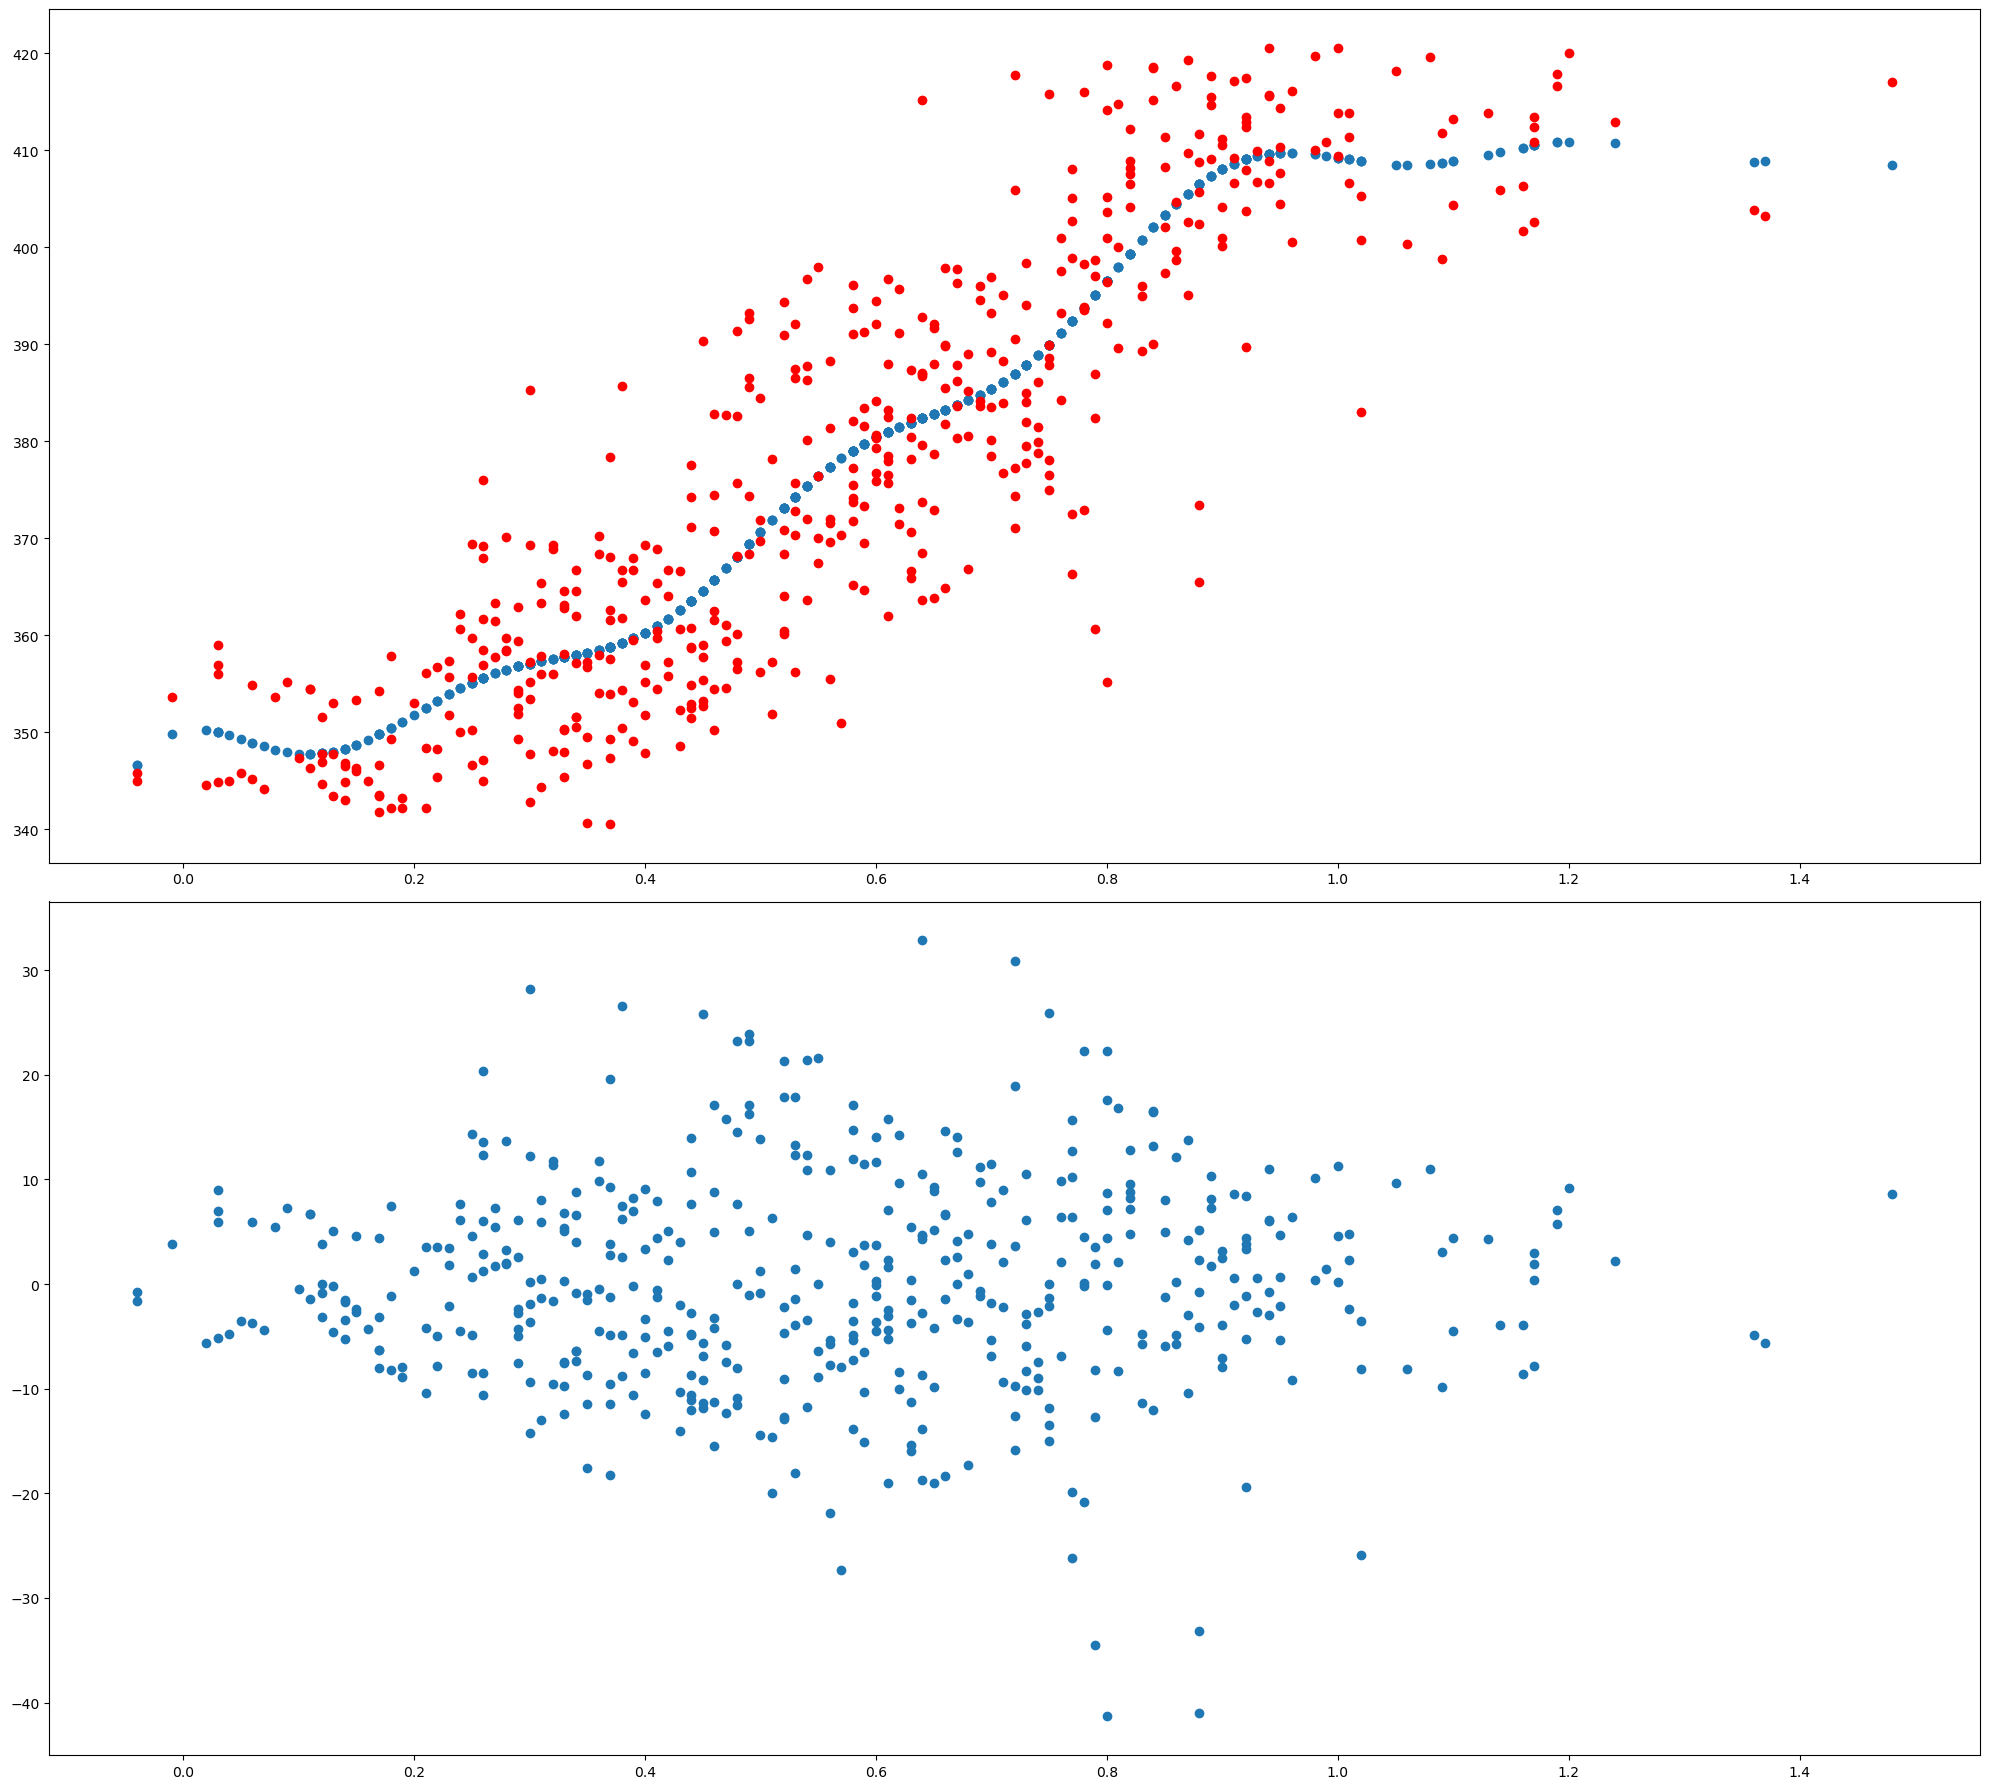

In [10]:
anm = ANM()
y, x = earth_data.data['co2_average'], earth_data.data['temp_change']
pred_y = anm.fit_gp(x.to_numpy().reshape(-1,1), y.to_numpy().reshape(-1,1))

fig, axes = plt.subplots(2, 1, figsize=(20,18))
axes[0].scatter(x, pred_y)
axes[0].scatter(x, y, color='red')

axes[1].scatter(x, y - pred_y.flatten())

In [11]:
from causallearn.utils.KCI.KCI import KCI_UInd
kci = KCI_UInd(kernelX='Gaussian', kernelY='Gaussian')

kci.compute_pvalue(x.to_numpy().reshape(-1,1), (y - pred_y.flatten()).to_numpy().reshape(-1,1))

(4.92915114946868e-07, 778.7558428129257)

(array([19., 51., 85., 85., 91., 80., 50., 15.,  4.,  3.]),
 array([-0.04 ,  0.112,  0.264,  0.416,  0.568,  0.72 ,  0.872,  1.024,
         1.176,  1.328,  1.48 ]),
 <BarContainer object of 10 artists>)

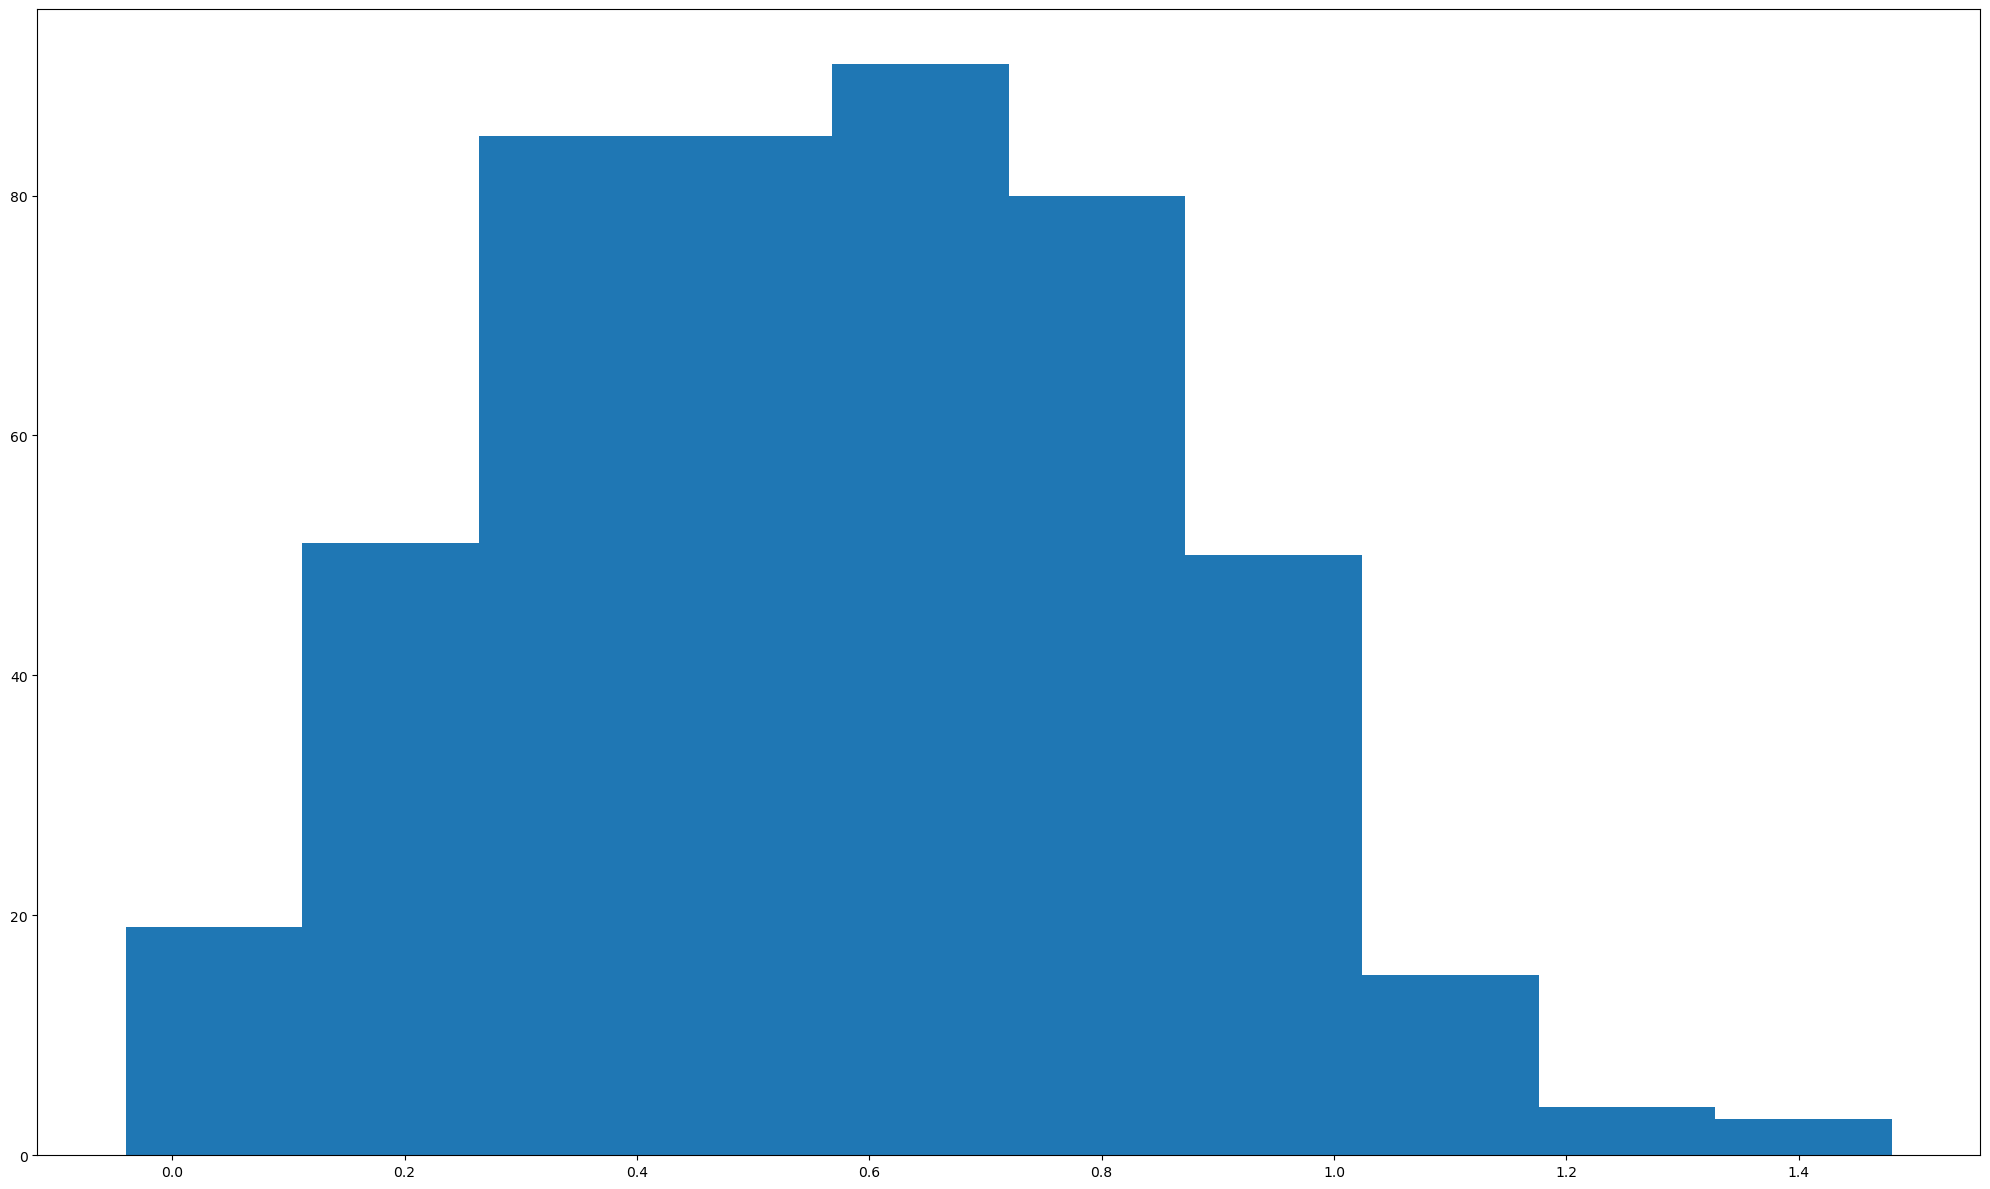

In [12]:
# plt.hist(y - pred_y.flatten())
plt.hist(x)